<a href="https://colab.research.google.com/github/ckj18/ToBigs_workspace/blob/main/week7_nlp_basic_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Basic Assignment
## NLP 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [ ]:
# 필요한 모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 7주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [ ]:
spam = pd.read_csv('spam.csv')

In [ ]:
spam.iloc[5]['v2']

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [ ]:
spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
spam.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


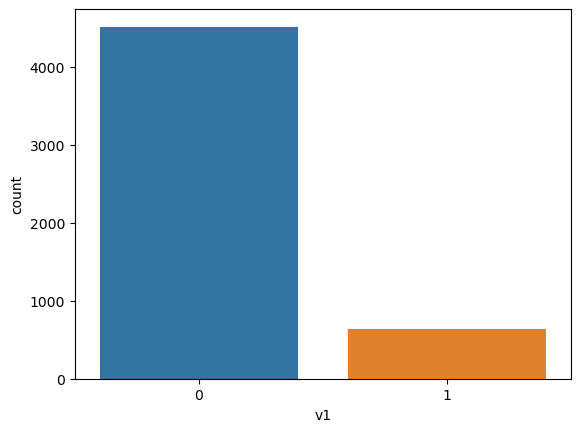

In [ ]:
# label 데이터 확인
sns.countplot(x='v1', data=spam)
plt.show()

## Tokenizing


In [ ]:
import nltk
import re

In [ ]:
# 정규표현식 사용(특수문자 제거)
spam['v2'] = spam['v2'].str.replace("[^a-zA-Z]", " ")

# 소문자로 통일
spam['v2'] = spam['v2'].str.lower()
spam.head()

C:\Users\chlru\AppData\Local\Temp\ipykernel_14664\1652509083.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  spam['v2'] = spam['v2'].str.replace("[^a-zA-Z]", " ")


,v1,v2
0,ham,go until jurong point crazy available only ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives aro...


In [ ]:
# label 데이터 인코딩
spam.v1 = spam.v1.replace(['ham','spam'],[0,1])

In [ ]:
# 중복 데이터 제거
spam.drop_duplicates(subset=['v2'], inplace=True)

In [ ]:
# 인덱스 초기화
spam = spam.reset_index()

In [ ]:
# 결측값 확인
print(spam.isnull().sum())

index    0
v1       0
v2       0
dtype: int64


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chlru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chlru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
tokenized_dictionary = []
stop_words = set(stopwords.words('english'))

for sentence in tqdm(spam['v2']):
    tokenized_sentence = word_tokenize(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 처리
    tokenized_dictionary.append(stopwords_removed_sentence)
spam['v2'] = tokenized_dictionary

  0%|          | 0/5147 [00:00<?, ?it/s]

In [ ]:
spam.head()

,index,v1,v2
0,0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,1,0,"[ok, lar, joking, wif, u, oni]"
2,2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,4,0,"[nah, think, goes, usf, lives, around, though]"


In [ ]:
print(spam.iloc[5]['v2'])

['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv']


## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText가 있었습니다. 다양한 시도와 '비교' 결과를 함께 적어주세요! 파라미터를 조정해가는 과정도 해석에 도움이 될 수 있겠죠 :)

In [ ]:
pip install gensim

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec

# 메일 토큰 빈도
def token_frequency(data, label):
    CV = CountVectorizer(max_features= 300, stop_words = 'english')
    tokens_set = sum(data[data.v1 == label]['v2'], []) 
    CV_tokens = CV.fit_transform(tokens_set)
    
    token_freq = pd.DataFrame( {'token' : CV.get_feature_names(),
                           'frequency' : CV_tokens.sum(axis = 0).flat})
    
    return token_freq.sort_values('frequency', ascending = False)

# 메일 데이터 학습
def data_embedding(data, label, option):
    mail = 'spam' if label == 1 else 'ham'
    method = 'cbow' if option == 1 else 'skip'
        
    model = Word2Vec(data[data.v1 == label]['v2'],  # 리스트 형태의 데이터
                 sg=option,                         # 0: CBOW, 1: Skip-gram
                 window=3,                          # 고려할 앞뒤 폭(앞뒤 3단어)
                 min_count=3,                       # 사용할 단어의 최소 빈도(3회 이하 단어 무시)
                 workers=1)                         # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
    name = 'model_' + mail + '_' + method
    model.save(name)
    
    return name

In [ ]:
# 스팸 메일 토큰 빈도, label=1: spam
top10_list1 = token_frequency(data=spam, label=1)
top10_words1 = ' '.join(top10_list1['token'].values)

top10_list1.head(10)

C:\Users\chlru\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,token,frequency
87,free,196
257,txt,141
264,ur,117
235,stop,113
151,mobile,109
242,text,109
209,reply,95
41,claim,92
291,www,83
199,prize,77


In [ ]:
# Non-스팸 메일 토큰 빈도, label=0: ham
top10_list2 = token_frequency(data=spam, label=0)
top10_words2 = ' '.join(top10_list2['token'].values)

top10_list2.head(10)

C:\Users\chlru\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,token,frequency
90,gt,288
142,lt,287
178,ok,255
88,got,239
122,know,225
133,like,222
87,good,215
40,come,212
265,ur,198
251,time,192


## CBOW

In [ ]:
# 스팸 메일 데이터 학습 
save_name1 = data_embedding(data=spam, label=1, option=0)
model_spam_cbow = Word2Vec.load(save_name1)

In [ ]:
# Non-스팸 메일 데이터 학습 
save_name2 = data_embedding(data=spam, label=0, option=0)
model_ham_cbow = Word2Vec.load(save_name2)

In [ ]:
print("top10 단어들 중 스팸메일과 관련없는 단어: ", model_spam_cbow.wv.doesnt_match(list(top10_list1['token'].head(10).values)))

top10 단어들 중 스팸 메일과 관련없는 단어:  mobile


In [ ]:
model_spam_cbow.wv.most_similar('free')

[('call', 0.9935528039932251),
 ('txt', 0.9920119047164917),
 ('text', 0.9918273687362671),
 ('www', 0.9915254712104797),
 ('u', 0.9915177822113037),
 ('p', 0.9904283881187439),
 ('ur', 0.9893534183502197),
 ('send', 0.9885872006416321),
 ('claim', 0.9883125424385071),
 ('reply', 0.9882644414901733)]

In [ ]:
model_spam_cbow.wv.most_similar(
    positive=['free', 'txt'], negative= ['ok'], topn=5)

[('get', 0.876031756401062),
 ('send', 0.8756096363067627),
 ('po', 0.8748683929443359),
 ('www', 0.8723924160003662),
 ('network', 0.8720965385437012)]

In [ ]:
print("top10 단어들 중 Non-스팸메일과 관련없는 단어: ", model_ham_cbow.wv.doesnt_match(list(top10_list2['token'].values)))

top10 단어들 중 관련없는 단어:  lt


In [ ]:
# 빈도수가 높은 gt나 lt은 의미파악이 어렵기에 그 다음으로 높은 ok로 분석
model_ham_cbow.wv.most_similar('ok')

[('go', 0.9994848966598511),
 ('n', 0.9994502663612366),
 ('u', 0.9994451999664307),
 ('need', 0.9994205832481384),
 ('ur', 0.999419093132019),
 ('much', 0.9994160532951355),
 ('said', 0.9994127750396729),
 ('got', 0.9993934631347656),
 ('well', 0.9993862509727478),
 ('time', 0.9993810057640076)]

In [ ]:
model_ham_cbow.wv.most_similar(
    positive=['ok', 'know'], negative= ['free'], topn=5)

[('go', 0.9988881349563599),
 ('going', 0.998853862285614),
 ('much', 0.9988292455673218),
 ('u', 0.9988096356391907),
 ('thanks', 0.998799741268158)]

## Skip-gram

In [ ]:
# 스팸 메일 데이터 학습 
save_name1 = data_embedding(data=spam, label=1, option=1)
model_spam_skip = Word2Vec.load(save_name1)

In [ ]:
# Non-스팸 메일 데이터 학습 
save_name2 = data_embedding(data=spam, label=0, option=1)
model_ham_skip = Word2Vec.load(save_name2)

In [ ]:
print("top10 단어들 중 스팸메일과 관련없는 단어: ", model_spam_skip.wv.doesnt_match(list(top10_list1['token'].head(10).values)))

top10 단어들 중 스팸메일과 관련없는 단어:  prize


In [ ]:
model_spam_skip.wv.most_similar('free')

[('get', 0.9983793497085571),
 ('send', 0.9982302784919739),
 ('text', 0.9982255697250366),
 ('txt', 0.9982095956802368),
 ('msg', 0.9981926679611206),
 ('win', 0.9981400966644287),
 ('phone', 0.9981259107589722),
 ('week', 0.9981170296669006),
 ('customer', 0.9980934262275696),
 ('mob', 0.9980892539024353)]

In [ ]:
model_spam_skip.wv.most_similar(
    positive=['free', 'txt'], negative= ['ok'], topn=5)

[('get', 0.9931764006614685),
 ('send', 0.9926524758338928),
 ('name', 0.9925177097320557),
 ('customer', 0.9923964142799377),
 ('lucky', 0.9922888278961182)]

In [ ]:
print("top10 단어들 중 Non-스팸메일과 관련없는 단어: ", model_ham_skip.wv.doesnt_match(list(top10_list2['token'].head(10).values)))

top10 단어들 중 Non-스팸메일과 관련없는 단어:  gt


In [ ]:
model_ham_skip.wv.most_similar('ok')

[('quite', 0.9982573986053467),
 ('go', 0.9981889724731445),
 ('eat', 0.9981884360313416),
 ('said', 0.9981714487075806),
 ('ask', 0.9981690645217896),
 ('free', 0.9981569647789001),
 ('lar', 0.9981010556221008),
 ('already', 0.9981000423431396),
 ('ah', 0.9980812668800354),
 ('wif', 0.998053789138794)]

In [ ]:
model_ham_skip.wv.most_similar(
    positive=['ok', 'know'], negative= ['free'], topn=5)

[('thought', 0.9965002536773682),
 ('bad', 0.9964239001274109),
 ('person', 0.996334969997406),
 ('means', 0.9963159561157227),
 ('thinking', 0.9963077902793884)]

## FastText

In [ ]:
from gensim.models import FastText

# 스팸 메일 데이터 학습 
model_spam_fast = FastText(spam[spam.v1 == 1]['v2'], window=3, min_count=3, workers=1)

In [ ]:
model_spam_fast.wv.most_similar("free")

[('freephone', 0.9998477697372437),
 ('call', 0.9998305439949036),
 ('caller', 0.9998200535774231),
 ('calling', 0.9998183846473694),
 ('freefone', 0.9998025894165039),
 ('collection', 0.9998019337654114),
 ('phone', 0.9998003840446472),
 ('tone', 0.9997974038124084),
 ('replying', 0.99979567527771),
 ('awaiting', 0.9997943639755249)]

In [ ]:
model_ham_fast = FastText(spam[spam.v1 == 0]['v2'], window=3, min_count=5, workers=1)

In [ ]:
model_ham_fast.wv.most_similar("ok")

[('either', 0.9999462366104126),
 ('already', 0.9999455809593201),
 ('asking', 0.9999452829360962),
 ('remember', 0.9999447464942932),
 ('another', 0.9999439120292664),
 ('alright', 0.9999436736106873),
 ('dinner', 0.9999427795410156),
 ('sister', 0.9999425411224365),
 ('think', 0.9999425411224365),
 ('thinking', 0.9999422430992126)]

#### 결과 정리
###### 1. 스팸메일 단어 빈도수가 가장 높은 단어: free
###### 2. Non-스팸메일 단어 빈도수가 가장 높은 단어: gt(의미불분명이기에 ok로 비교)

###### 2. CBOW
    1) top10 words 중에 스팸메일과 관련없는 단어: mobile 
    2) top10 words 중에 Non-스팸메일과 관련없는 단어: lt
    3) free와 관련이 높은 단어: call, txt, text, www, u, p, ur, send, claim, reply
    4) ok와 관련이 높은 단어: go, n, u, need, ur, much, said, got, well, time
    5) free, txt에 가깝고 ok에 먼 단어들: get, send, po, www, network
    6) ok, know에 가깝고 free에 먼 단어들: go, going, much, u, thanks

###### 3. Skip-gram
    1) top10 words 중에 스팸메일과 관련없는 단어: prize 
    2) top10 words 중에 Non-스팸메일과 관련없는 단어: gt
    3) free와 관련이 높은 단어: get, send, text, txt, msg, win, phone, week, customer, mob
    4) ok와 관련이 높은 단어: quite, go, eat, said, ask, free, lar, already, ah, wif
    5) free, txt에 가깝고 ok에 먼 단어들: get, send, name, customer, lucky
    6) ok, know에 가깝고 free에 먼 단어들: thought, bad, person, means, thinking
    
###### 4. FastText
    1) free와 관련이 높은 단어: freephone, call, caller, calling, freefone, collection, phone, tone, replying, awaiting
    2) ok와 관련이 높은 단어: either, already, asking, remember, another, alright, dinner, sister, think, thinking

###### 5. 결론
    1) CBOW보다는 Skip-gram의 결과가 스팸메일과 Non-스팸메일 구분이 분명함
    2) Skip-gram과 FastText의 결과를 비교했을 때, free와 관련성이 높은 단어들이 많고 단어들 간 비슷한 부분이 많기에 스팸메일 단어를 학습하는 데는 FastText가 더 적합함

## 본인이 도출해낸 해석을 적어주세요!

- 유사도, Wordcloud, 이진 분류 모델, Plot 뭐든 상관없으니 분명하고 인상적인 해석을 적어주시면 됩니다.

In [ ]:
# free의 경우 단어들은 전화요금, 핸드폰과 연관되어 있음
model_spam_fast.wv.most_similar("free")

[('freephone', 0.9998477697372437),
 ('call', 0.9998305439949036),
 ('caller', 0.9998200535774231),
 ('calling', 0.9998183846473694),
 ('freefone', 0.9998025894165039),
 ('collection', 0.9998019337654114),
 ('phone', 0.9998003840446472),
 ('tone', 0.9997974038124084),
 ('replying', 0.99979567527771),
 ('awaiting', 0.9997943639755249)]

In [ ]:
# stop의 경우 단어들은 내용, 벨소리, 핸드폰, 전화와 연관되어 있음
model_spam_fast.wv.most_similar("stop")

[('content', 0.999742865562439),
 ('receive', 0.99974125623703),
 ('ringtone', 0.9997325539588928),
 ('tone', 0.9997283220291138),
 ('collection', 0.9997177720069885),
 ('phone', 0.999714195728302),
 ('call', 0.9997122883796692),
 ('collect', 0.9997115731239319),
 ('text', 0.9997100830078125),
 ('calling', 0.9997073411941528)]

In [ ]:
# text의 경우 단어들은 전화, 구독, 벨소리와 연관되어 있음
model_spam_fast.wv.most_similar("text")

[('call', 0.9998622536659241),
 ('texts', 0.9998503923416138),
 ('collection', 0.999839723110199),
 ('subscription', 0.9998251795768738),
 ('national', 0.9998177886009216),
 ('ringtone', 0.999813973903656),
 ('caller', 0.9998120069503784),
 ('collect', 0.9998114109039307),
 ('selection', 0.9998102784156799),
 ('tone', 0.9998089671134949)]

In [ ]:
# reply의 경우 단어들은 답장, 선택, 구독, 모바일, 전화와 연관되어 있음
model_spam_fast.wv.most_similar("reply")

[('replying', 0.9999053478240967),
 ('selection', 0.9998420476913452),
 ('tone', 0.9998342990875244),
 ('collection', 0.9998290538787842),
 ('call', 0.9998251795768738),
 ('subscriber', 0.9998118877410889),
 ('action', 0.9998113512992859),
 ('mobile', 0.9998066425323486),
 ('collect', 0.999805748462677),
 ('contacted', 0.9998019337654114)]

In [ ]:
# www의 경우 단어들은 벨소리, 송신, 주문과 연관되어 있음
model_spam_fast.wv.most_similar("www")

[('ringtone', 0.9994662404060364),
 ('ring', 0.9994396567344666),
 ('ringtones', 0.9994311928749084),
 ('tones', 0.9994274377822876),
 ('send', 0.9994267225265503),
 ('tone', 0.9994252920150757),
 ('co', 0.9994238018989563),
 ('one', 0.9994162917137146),
 ('weekly', 0.9994137287139893),
 ('order', 0.9994038343429565)]

In [ ]:
# prize의 경우 단어들은 보상, 선택, 전화와 연관되어 있음
model_spam_fast.wv.most_similar("prize")

[('prizes', 0.9998217821121216),
 ('call', 0.999726414680481),
 ('text', 0.9996929168701172),
 ('national', 0.9996912479400635),
 ('collection', 0.9996904730796814),
 ('tones', 0.9996784925460815),
 ('tone', 0.9996753931045532),
 ('calling', 0.9996752142906189),
 ('selection', 0.9996703267097473),
 ('awarded', 0.9996669292449951)]

##### 종합: 스팸메일은 전화요금, 핸드폰, 보상, 구독, 주문, 벨소리, 선택 등과 같은 단어들과 연관성이 높음
 

#### 시각화

In [ ]:
pip install wordcloud


     -------------------------------------- 153.1/153.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

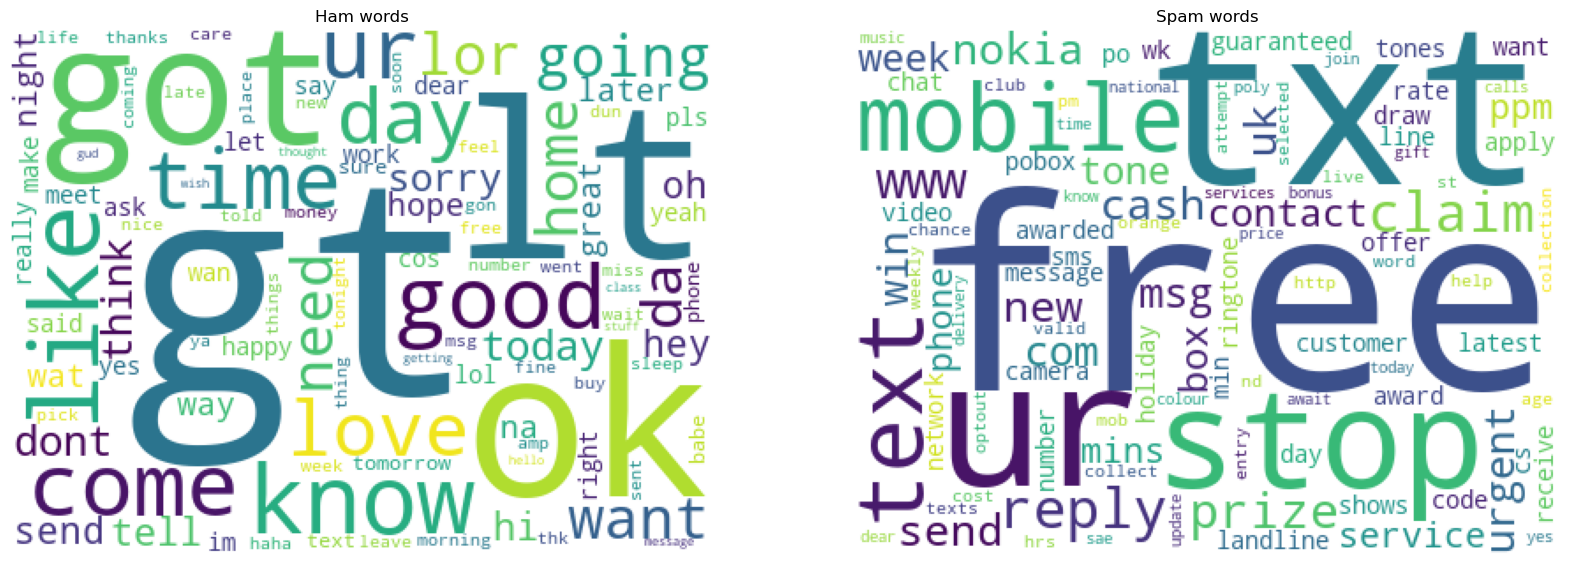

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title('Ham words')
ham_words = dict(zip(top10_list2['token'], top10_list2['frequency']))
Cloud = wc.generate_from_frequencies(ham_words)
plt.axis('off')
plt.imshow(Cloud)

plt.subplot(1,2,2)
plt.title('Spam words')
spam_words = dict(zip(top10_list1['token'], top10_list1['frequency']))
Cloud = wc.generate_from_frequencies(spam_words)
plt.axis('off')
plt.imshow(Cloud)

### Ham
    감정을 나타내는 단어들이 있는 경우가 많음
    
### Spam
    공짜, txt파일, 보상, 현금, www 같은 단어들이 있는 경우가 많음